(Lecture8_Part2_SPH_Algorithm_For_Energy_Equation)=
# Lecture8_Part2_SPH_Algorithm_For_Energy_Equation

Since we have the Navier-Stoke equation for simulating fluid, we can break it down to simulate the movement of individual fluid particles, for a particle $i$, we have

$$\frac{\text{d}\vec{v_i}}{\text{d}t}=\vec{g} - \frac{1}{\rho_i}\nabla p + \frac{\mu}{\rho_i} \nabla^{2}\vec{v}$$(equation8_2_1)

## Mathematics for SPH

Smoothed-particle hydrodynamics (SPH) is a computational method used for simulating the mechanics of continuum media, such as solid mechanics and fluid flows. It can be used to solve the equation {eq}`equation8_2_1` for any quantity $Q$ of one particle. It is a meshfree Lagrangian method(where the co-ordinates move with the fluid), and the resolution of the method can easilybe adjusted with respect to variables such as density.

The key assumption of the SPH method is that calculations are based on a weighted average (by $W(r_i-r_j,h)$) of field values. $W$ will give more strength to points that are closer and make points that are further away have a weaker influence. At points that are more than a certain distance away, $W$ will become zero, which means those points would not have any influence at all.

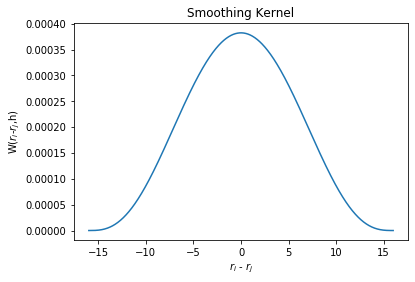

In [71]:
import numpy as np
import matplotlib.pyplot as plt
N  = 1000    # number of points to plot (ignore)
h = 16.0
ri_minus_rj = np.linspace(-h, h, N)
def W(ri_minus_rj, h):
    return 315/(64*np.pi*h**9)*(h**2 - ri_minus_rj**2)**3

plt.figure()
plt.plot(ri_minus_rj, W(ri_minus_rj,h))
plt.xlabel('$r_i$ - $r_j$')
plt.ylabel('W($r_i$-$r_j$,h)')
plt.title('Smoothing Kernel')
plt.show()

The general expression for any quantity $A_{i}$ is given below:

$$A_{i}(r_{i})=\int_{}^{} A(r_{j})W(r_{i}-r_{j},h)dr_{j}\approx\sum_{j}A(r_{i})W(r_{i}-r_{j},h)$$(equation8_2_2)

 where $r_{j}$ is the location of a neighboring point and $r_{i}$ is the location of our point; $h$ is the interaction radius, the points that are more than $h$ away will stop interacting with our point.

So for density, the discrete sum of approximation is

$$A_{i}(r_{i})=\rho(r_i)\approx\sum_{j}\frac{\rho(r_{j})}{\rho(r_j)}W(r_{i}-r_{j},h)m_j\approx\sum_{j}W(r_{i}-r_{j},h)m_j$$(equation8_2_3)

Then we can find the pressure gradient $\nabla p$

$$\nabla p (r_i)=\sum \frac{m_j p_j}{\rho_j} \nabla_i W(r_i-r_j,h)$$ (equation8_2_4)

But this equation does not obey the conservation of momentum because it does not have the right symmetry (force derived from this equation felt by particle A from B does not equal to the force felt by B from A). To conserve quantities, we can apply Lagrangian, then the equation becomes:

$$\frac{\nabla p} {\rho}=\nabla( \frac{p}{\rho})+\frac{p}{\rho^2} \nabla \rho$$ (equation8_2_5)

 where $\nabla(\frac{p}{\rho})=\frac{\nabla p}{\rho}+p \nabla(\frac{1}{\rho})$, and $p\nabla(\frac{1}{\rho})=-\frac{p}{\rho^2}\nabla \rho$.

So instead of the approximation from equation {eq}`equation8_2_4`, we could have the following expression by plugging the $\rho, p, \nabla p \&\nabla \rho$ into equation {eq}`equation8_2_5`, keeping the momentum a constant:

$$-\frac{\nabla p_i} {\rho_i}\approx-\sum_j m_j (\frac{p_i}{\rho_i^2}+\frac{p_j}{\rho_j^2})\nabla_i W(r_i-r_j,h)$$ (equation8_2_6)

 where $W(r_i-r_j,h)\propto e^{\frac{-r_{ij}^2}{h^2}}$ (Gaussian Distribution).

Last but not least, we can apply the same techniques to approximate the viscosity term $\frac{\mu}{\rho_i} \nabla^{2}\vec{v_i}$.

$$\frac{\mu}{\rho_i} \nabla^{2}\vec{v_i}\approx\frac{\mu}{\rho_i}\sum_j m_j \left[\frac{v_j-v_i}{\rho_j}\right]\nabla^{2}W(r_i-r_j,h)$$ (equation8_2_7)

## From Navier-Stoke to SPH

In [72]:
# Open Anaconda Prompt (anaconda 3), then type
#pip install ipyvolume
#pip install bqplot
#jupyter nbextension enable –py bqplot
import ipyvolume as ipv
import bqplot.scales
import numpy as np
from numpy import random
import ipywidgets as widgets    # https://www.youtube.com/watch?v=hOKa8klJPyo
import matplotlib.cm as cm    # for coloring temperature

In [73]:
# some constants
G = np.array([0.0,-9.8,0.0]); # external (gravitational) forces
REST_DENS = 1000.0; # rest density of liquid
GAS_CONST = 2000.0; # const for equation of state
H = 16.0; # kernel radius
HSQ = H*H; # radius^2 for optimization
T0 = 1.0    # initial temperature of the fluid
T_bottom = 1.5    # bottom heating temperature
T_ceiling = 0.5    # upper cooling temperature
alpha_v = 0.0002    # thermal expansion coefficient
k = 0.0003    # thermal conductivity of the particle
k_wall = 100.0    # thermal conductivity of the wall
MASS = 65.0; # assume all particles have the same mass
VISC = 250.0; # viscosity constant
dt = 0.0008; # integration timestep

# smoothing kernels defined in Müller and their gradients
POLY6 = 315.0/(65.0*np.pi*H**9);
SPIKY_GRAD = -45.0/(np.pi*H**6);
VISC_LAP = 45.0/(np.pi*H**6);

# simulation parameters
EPS = H; # boundary epsilon
BOUND_DAMPING_NORMAL = -0.0;    # particle does not bounce back vertically
BOUND_DAMPING_HORIZONTAL = 0.0;    # no slip-boundary

# solver data
Fluid_Particles_list = [];
X = [[],[],[]]    # positions for all particles
Ts = []    # temperature of all particles

# interaction
MAX_PARTICLES = 3000;

# rendering projection parameters
WINDOW_WIDTH = 425;
WINDOW_HEIGHT = 150;
WINDOW_DEPTH = 300

VIEW_WIDTH = 1.5*WINDOW_WIDTH;
VIEW_HEIGHT = 1.5*WINDOW_HEIGHT;
VIEW_DEPTH = 1.5*WINDOW_DEPTH;

In [74]:
# particle data structure
# stores position, velocity, and force for integration
# stores density (rho) and pressure values for SPH
class Particle:
    def __init__(self, X, V, F, rho, p, T):
        self.X = X   # x position vector
        self.V = V    # velocity vector
        self.F = F    # force vector
       
        self.rho = 0.0    # density of the fluid at the position of the particle
        self.p = p    # pressure of the fluid at the position of the particle
        self.T = T0    # temperature of the fluid at the position of the particle

In [75]:
def InitSPH():
    global X
    global fig
    global scatter
    global ipv
    global Ts
    # for 3d simulation, un-comment the following 2 lines and indent the codes below
    #for zi in range(int(2*EPS),int(WINDOW_DEPTH-EPS*2.0),int(H)):
        #zi += H
    for yi in range(int(1*EPS), int(WINDOW_HEIGHT-EPS*1.0), int(H*1/16)):
        yi += H #+random.rand()*H/1000
        for xi in range(0, int(WINDOW_WIDTH), int(H)):
            if len(Fluid_Particles_list) < MAX_PARTICLES:
                xi += H #+random.rand()*H/1000

                Vx = 0.0    # gives the particle a random tiny initial velocity in the x-direction
                Vy = 0.0    # gives the particle a random tiny initial velocity in the y-direction
                Vz = 0.0
                V = np.array([Vx,Vy,Vz])
                
                Fx = 0.0    # gives the particle a random tiny initial force in the x-direction
                Fy = 0.0    # gives the particle a random tiny initial force in the y-direction
                Fz = 0.0
                F = np.array([Fx,Fy,Fz])
                
                rho = 0.0
                p = 0.0
                T = T0
                
                # for 3d simulation, delete the line below
                zi = 2*EPS    # make position in z-direction the same because its a 2d problem
                
                Xi = np.array([xi + np.random.random_sample(),yi + np.random.random_sample(),zi])# + np.random.random_sample(); for 3d simulation
                
                Fluid_Particles_list.append(Particle(Xi,V,F,rho,p,T))
    # for 3d simulation, indent the codes above
    for pi in Fluid_Particles_list:
          
        X[0].append(pi.X[0])
        X[1].append(pi.X[1])
        X[2].append(pi.X[2])
        Ts.append(np.array([pi.T,pi.T,pi.T])) 
        
    x = np.array(X[0])
    y = np.array(X[1])
    z = np.array(X[2])
    
    # the scale does not seem to work...
    scales = {
    'x': bqplot.scales.LinearScale(min=0, max=VIEW_WIDTH),
    'y': bqplot.scales.LinearScale(min=0, max=VIEW_HEIGHT),
    'z': bqplot.scales.LinearScale(min=0, max=VIEW_DEPTH),
}
    
    fig = ipv.figure(scales=scales)
    Ts = np.array(Ts)
    Ts -= Ts.min()
    Ts /= Ts.max()
    colors = Ts
    scatter = ipv.scatter(x,y,z,marker='sphere',color=colors)
    
    scatter.size = 3
    
    ipv.show()
    print("initializing mantle convection with " )
    print(len(x))
    print("particles")

In order to compute the $\frac{\text{d}\vec{v_i}}{\text{d}t}$ at every point for equation {eq}`equation1`, we need to calculate the following equations respectively:

$$T_{i} \approx \sum_{j}(T_j-T_i) k dt \nabla W(r_i-r_j,h) \approx \sum_{j}(T_j-T_i) k dt \frac{315}{64\pi h^{9}}(h^{2}-\parallel r_i - r_j\parallel^2)^{3}$$(equation8_2_8)

$$\rho_{i} \approx \sum_{j} m_{j}\frac{315}{64\pi h^{9}}(h^{2}-\parallel r_i - r_j\parallel^2)^{3}$$ (equation8_2_9)

Considering the effect of temperature to the change of density we have

$$\rho_{i} = \rho_{i} \cdot(1 - \alpha_v \cdot (T_i-T_0))$$ (equation8_2_10) 

where $\alpha_v$ is the thermal expansion coefficient and $T_0$ is the original temperature of that particle $i$.

Note that $T$ and $\rho_i$ are obtained before calculating the pressure gradient and viscosity term.

$$p_i = k(\rho_i - \rho_0)T_i$$ (equation8_2_11)

 where $k$ is a constant, $\rho_0$ is the resting density (density of fluid at equilibrium).

In [76]:
def ComputeDensityPressureTemperature():
    for pi in Fluid_Particles_list:
        pi.rho = 0.0
        dT = 0.0    # the change in temperature
        for pj in Fluid_Particles_list:
            h = np.linalg.norm(pi.X - pj.X)
            if (h<H):
                pi.T += (pj.T - pi.T) * k * dt *POLY6*(HSQ-h**2)**3;
                pi.rho += MASS*POLY6*(HSQ-h**2)**3;
        
        pi.rho -= pi.rho * alpha_v *(pi.T - T0)
        pi.p = GAS_CONST*(pi.rho - REST_DENS) * pi.T;

Then we can compute the pressure and viscosity term

$$\frac{\nabla p_{i}}{p_{i}}\approx\sum_j m_{j}\left[\frac{p_i}{\rho_i^{2}}+\frac{p_j}{\rho_j^{2}}\right]\frac{-45}{\pi h^{6}}(h-\parallel r_i - r_j\parallel)^2\frac{r_i-r_j}{\parallel r_i - r_j\parallel}$$ (equation8_2_12)

and

$$\frac{\mu}{\rho_i} \nabla^{2}\vec{v_i}\approx\frac{\mu}{\rho_i}\sum_j m_j \left[\frac{v_j-v_i}{\rho_j}\right]\frac{45}{\pi h^{6}}(h-\parallel r_i - r_j\parallel)$$ (equation8_2_13)

After equation {eq}`equation8_2_10` to {eq}`equation8_2_13` are computed, we can put them together into N-S equation to obtain acceleration.

In [77]:
def ComputeForces():
    
    for pi in Fluid_Particles_list:
        
        fpress = 0.0
        fvisc = 0.0

        for pj in Fluid_Particles_list:
            
            d = pj.X - pi.X
            h = np.linalg.norm(d)
            r = d/h

            
            if (pi==pj):
                continue;
            
            if (h<H):
                
                # compute pressure force contribution
                fpress += - r * MASS * (pi.p + pj.p) / (2*pj.rho)  * SPIKY_GRAD * (H-h)**2
              
                # compute viscosity force contribution
                fvisc += VISC * MASS * (pj.V - pi.V) / (pj.rho)  * VISC_LAP * (H-h);
            

        fgrav = G*pi.rho
        pi.F = fpress + fvisc + fgrav    

And then we can use a simple time stepping numerical integration scheme to advance the velocity and position of particles.

In [78]:
def Integrate():
    for p in Fluid_Particles_list:
        # forward Euler integration
        p.V += dt*(p.F)/p.rho;   
        p.V[2] = 0.0
        p.X += dt*p.V;
  
        if (p.X[0] - EPS < 0.0):    # left boundary condition
            p.V[0] *= 1.0 #BOUND_DAMPING_NORMAL
            p.X[0] = WINDOW_WIDTH - EPS    # coming out from the right boundary
            p.V[1] *= BOUND_DAMPING_HORIZONTAL
            #p.Vz *= BOUND_DAMPING_HORIZONTAL
        
        if (p.X[0] + EPS > WINDOW_WIDTH):    # right boundary condition
            p.V[0] *= 1.0 #BOUND_DAMPING_NORMAL
            p.X[0] = EPS    # coming out from the left boundary
            p.V[1] *= BOUND_DAMPING_HORIZONTAL
            #p.Vz *= BOUND_DAMPING_HORIZONTAL

        if (p.X[1] - EPS < 0.0):    # bottom boundary condition
            p.V[1] *= BOUND_DAMPING_NORMAL
            p.X[1] = EPS
            p.V[0] *= BOUND_DAMPING_HORIZONTAL
            
            p.T += (T_bottom - p.T) * k_wall * dt    # heating from the bottom
            #p.Vz *= BOUND_DAMPING_HORIZONTAL
            
        if (p.X[1] + EPS > WINDOW_HEIGHT):    # upper boundary condition
            p.V[1] *= BOUND_DAMPING_NORMAL
            p.X[1] = WINDOW_HEIGHT - EPS 
            p.V[0] *= BOUND_DAMPING_HORIZONTAL
            
            p.T += (T_ceiling - p.T) * k_wall * dt    # cooling from the ceiling
            #p.Vz *= BOUND_DAMPING_HORIZONTAL
         
        # only for 3D boundary condition (in the z-direction)
        if (p.X[2] - EPS < 0.0):    # front boundary condition
            p.V[2] *= BOUND_DAMPING_NORMAL
            p.X[2] = EPS
            #p.Vx *= BOUND_DAMPING_HORIZONTAL
            #p.Vy *= BOUND_DAMPING_HORIZONTAL
            
        if (p.X[2] + EPS > WINDOW_DEPTH):    # back boundary condition
            p.V[2] *= BOUND_DAMPING_NORMAL
            p.X[2] = WINDOW_DEPTH - EPS 
            #p.Vx *= BOUND_DAMPING_HORIZONTAL
            #p.Vy *= BOUND_DAMPING_HORIZONTAL

In [79]:
def Update():
    print("start updating")
    ComputeDensityPressureTemperature()
    ComputeForces()
    Integrate()    
    x =[]
    y =[]
    z =[]
    Ts = []
    for pi in Fluid_Particles_list:
        x.append(pi.X[0])
        y.append(pi.X[1])
        z.append(pi.X[2])
        Ts.append(np.array([pi.T,pi.T,pi.T])) 
    
    for n in Ts:
        max_ = 1.5
        min_ = 1.5
        temperature = n[0]
        if (temperature > max_):
            max_ = temperature
        if (temperature < min_):
            min_ = temperature

            
    Ts = np.array(Ts)
    Ts -= Ts.min()
    Ts /= Ts.max()
    colors = Ts
    scatter.x=np.array(x)
    scatter.y=np.array(y)
    scatter.z=np.array(z)
    scatter.color=colors

In [80]:
InitSPH()

C:\Users\JianouJiang\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


initializing mantle convection with 
3000
particles


In [ ]:
# Run this code to update the mantle convection
TotalTime = 1000
iterations = int(TotalTime/dt)
print("start iterating")
for time in range(iterations):
    Update()
    print("iterations")
    print(time)   

start iterating
start updating


C:\Users\JianouJiang\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


iterations
0
start updating
iterations
1
start updating


C:\Users\JianouJiang\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


iterations
2
start updating
iterations
3
start updating
iterations
4
start updating
iterations
5
start updating
iterations
6
start updating
iterations
7
start updating


The simulation takes hours because each iteration is time consuming. The figure below shows the result after many iterations. One problem of this simulation is the boundary condition, where particles are sticked to the wall when they are in contact with it. This means that after many iterations, all particles will be sticked to the wall and the fluid dynamics would be poorly simulated.

<img src='img/mantle_convection_thermal.PNG' width=600>


Figure 1: Two-dimensional cellular convection in a fluid layer heated from below simulation shows similar character as the figure 6.38 in the book called $Geodynamics$,[Turcotte_D.L.,_Schubert_G.].

One way of resolving the problem is called the ghost particle. These virtual particle (ghost particle)will interact with the fluid particles through both pressure and shear stress. If no slip boundariesare required, then the reflected particles are given a velocity that has the same magnitude, butopposite direction to that of the matching particle, while for full slip boundary conditions thereflected particle has the same velocity.